In [2]:
import sys
import glob
import serial

def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

print(serial_ports())

['/dev/tty.E500Pro', '/dev/tty.Bluetooth-Incoming-Port']


In [2]:
import serial
import time
import struct
import numpy as np

for ports in serial_ports():
    print("READING PORTS")

    ser = serial.Serial(port=ports, baudrate=115200, timeout=.1)
    ser.write(bytes([126,1]))
    time.sleep(0.1)
    ser.write(bytes([127]))
    preamb = int.from_bytes(ser.read(4), byteorder='big')
    if preamb == 0:
        print("Wrong port number {}, continuing".format(ports))
        continue
    else:
        print("Correct port number {}, getting the configurations.".format(ports))

    configurations = np.frombuffer(ser.read(8), dtype=np.uint8, count=8)
    info_1 = {"Preamble: ": preamb, "Command code sent": configurations[0], 
                "Current DAQ configuration (board type)": configurations[1], 
                "Number of used ADC channels": configurations[2], 
                "Number of bytes in one channel of ADC": configurations[3],
                "Number of connected optical sensors": configurations[4], 
                "Number of channels of optical sensors": configurations[5],
                "Number of bytes in one optical channel": configurations[6], 
                "Sampling rate of optical sensor": configurations[7]}
    print("Configurations: ", info_1)
    ser.write(bytes([0, 6]))
    print("START ACQUISITION (0, 6)")
    preamb = int.from_bytes(ser.read(4), byteorder='big')
    start_info = np.frombuffer(ser.read(3), dtype=np.uint8, count=3)
    info_2 = {"Preamble: ": preamb, "ID": start_info[0], "Not used_1": start_info[1], "Not used_2": start_info[2]}
    print("START INFO: ", info_2)
    
    seconds = 10
    print("Starting data logger for {} seconds".format(seconds))
    start_time = time.time()
    end_time = start_time + seconds  # x seconds from now

    #my_array = np.zeros(size)
    size = 0;
    int_array_1 = np.zeros((1000, 3))
    int_array_2 = np.zeros((1000, 3))
    while time.time() < end_time:
#         config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
#         sensor_data = ser.read(12)
#         # Convert the byte string to a NumPy array of big-endian 32-bit integers
#         int_array = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
# #        int_array = int_array.byteswap()
#         print("Little: ", int_array)

        config_data = np.frombuffer(ser.read(8), dtype=np.uint8, count=8)#ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
        sensor_data = ser.read(12)
        
       
        # Convert the byte string to a NumPy array of big-endian 32-bit integers
        int_array_1[size] = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
        print(int_array_1[size])
        config_data = np.frombuffer(ser.read(8), dtype=np.uint8, count=8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
        
        sensor_data = ser.read(12)
        # Convert the byte string to a NumPy array of big-endian 32-bit integers
        int_array_2[size] = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
        print(int_array_2[size])
        size += 1

    print(size)
            
ser.write(struct.pack('b', -1))
print("STOP ACQUISITION")

READING PORTS
Wrong port number /dev/tty.E500Pro, continuing
READING PORTS
Wrong port number /dev/tty.Bluetooth-Incoming-Port, continuing
READING PORTS
Correct port number /dev/tty.usbmodem5D715F7938331, getting the configurations.
Configurations:  {'Preamble: ': 2857740885, 'Command code sent': 127, 'Current DAQ configuration (board type)': 2, 'Number of used ADC channels': 1, 'Number of bytes in one channel of ADC': 2, 'Number of connected optical sensors': 2, 'Number of channels of optical sensors': 3, 'Number of bytes in one optical channel': 4, 'Sampling rate of optical sensor': 100}
START ACQUISITION (0, 6)
START INFO:  {'Preamble: ': 2857740885, 'ID': 7, 'Not used_1': 2, 'Not used_2': 0}
Starting data logger for 10 seconds
[109442. 107026. 110624.]
[94012. 94162. 99055.]
[109426. 107131. 110636.]
[93989. 94189. 99133.]
[109440. 107033. 110585.]
[93990. 94153. 99089.]
[109380. 107025. 110613.]
[93968. 94113. 99161.]
[109358. 107065. 110631.]
[93940. 94150. 99055.]
[109393. 107074

[94167. 94027. 99109.]
[105441. 103121. 106762.]
[93229. 93032. 98117.]
[104757. 102367. 105964.]
[92361. 92268. 97347.]
[104001. 101659. 105282.]
[91481. 91354. 96522.]
[103344. 100969. 104614.]
[90739. 90595. 95733.]
[102719. 100421. 103969.]
[90078. 90069. 95053.]
[102082.  99776. 103342.]
[90057. 89481. 94580.]
[101482.  99281. 102788.]
[88984. 88845. 93954.]
[101025.  98727. 102284.]
[88491. 88467. 93496.]
[100490.  98213. 101823.]
[88042. 87959. 93019.]
[100009.  97736. 101319.]
[87733. 87668. 92666.]
[ 99554.  97265. 100757.]
[87320. 87234. 92206.]
[ 99069.  96782. 100334.]
[86885. 86892. 91838.]
[98457. 96238. 99816.]
[86559. 86453. 91379.]
[97883. 95644. 99170.]
[86051. 86067. 90951.]
[97314. 95089. 98567.]
[85553. 85664. 90526.]
[96653. 94454. 98056.]
[85227. 85093. 90012.]
[96012. 93871. 97327.]
[84720. 84723. 89602.]
[95399. 93248. 96748.]
[84028. 84169. 89072.]
[94757. 92608. 96089.]
[83557. 83626. 88551.]
[94016. 91890. 95366.]
[83086. 83094. 87936.]
[93355. 91236. 94707.

[87399. 85572. 88859.]
[78022. 78320. 83118.]
[87621. 85711. 88940.]
[78065. 78381. 83169.]
[87661. 85781. 89083.]
[78194. 78488. 83302.]
[87714. 85826. 89180.]
[78158. 78512. 83371.]
[87845. 85967. 89318.]
[78311. 78544. 83454.]
[87977. 86020. 89450.]
[78390. 78744. 83500.]
[88110. 86141. 89518.]
[78926. 79085. 84058.]
[88130. 86274. 89656.]
[78646. 78968. 83764.]
[88345. 86433. 89820.]
[78779. 79086. 83876.]
[88470. 86620. 89904.]
[78991. 79345. 84089.]
[88708. 86779. 90150.]
[79091. 79395. 84176.]
[88807. 86933. 90255.]
[79778. 79927. 84834.]
[88922. 87043. 90433.]
[79332. 79589. 84447.]
[89097. 87179. 90576.]
[79890. 79696. 84511.]
[89191. 87338. 90643.]
[79533. 79843. 84686.]
[89299. 87405. 90758.]
[79700. 79935. 84767.]
[89465. 87576. 90940.]
[79649. 79978. 84852.]
[89636. 87748. 91057.]
[79825. 80075. 84864.]
[89710. 87776. 91138.]
[79929. 80149. 84996.]
[89736. 87825. 91182.]
[79972. 80263. 85293.]
[89864. 87906. 91276.]
[80008. 80271. 85016.]
[89954. 88021. 91412.]
[80191. 803

[90594. 88009. 91342.]
[80565. 81217. 85805.]
[90601. 88026. 91396.]
[80508. 81428. 85752.]
[90586. 88029. 91547.]
[80497. 81432. 85716.]
[90603. 88043. 91769.]
[81010. 81637. 85718.]
[90576. 88113. 91902.]
[80525. 81577. 85952.]
[90510. 88068. 92095.]
[80552. 81469. 86177.]
[90543. 88122. 92078.]
[80595. 81397. 86320.]
[90554. 88303. 92060.]
[80558. 81337. 86399.]
[90451. 88515. 92117.]
[80667. 81371. 86541.]
[90410. 88639. 92070.]
[80791. 81458. 86443.]
[90383. 88810. 92094.]
[80954. 81594. 86419.]
[90418. 88909. 92076.]
[81196. 81661. 86261.]
[81295. 81836. 86309.]
[90382. 88914. 92132.]
[81350. 81717. 86310.]
[90322. 88882. 92116.]
[81687. 81635. 86487.]
[90195. 88835. 92018.]
[81437. 81458. 86531.]
[90150. 88813. 91935.]
[81293. 81055. 86664.]
[90161. 88831. 91998.]
[81240. 81074. 86706.]
[90124. 88778. 91832.]
[81251. 81060. 86606.]
[90216. 88850. 91844.]
[81297. 80998. 86526.]
[90170. 88750. 91745.]
[81406. 81009. 86287.]
[90149. 88682. 91685.]
[81601. 80967. 86002.]
[90173. 887

[90087. 88184. 91506.]
[80684. 80901. 85862.]
[90074. 88171. 91538.]
[80715. 80924. 85854.]
[90082. 88190. 91551.]
[80656. 80900. 85825.]
[90090. 88242. 91515.]
[80620. 80922. 85733.]
[90101. 88206. 91546.]
[80711. 80996. 85819.]
[90118. 88106. 91543.]
[80664. 80957. 85783.]
[90108. 88101. 91510.]
[80712. 80969. 85822.]
[90069. 88221. 91574.]
[80705. 80945. 85841.]
[90142. 88201. 91549.]
[80730. 80927. 85817.]
[90078. 88219. 91559.]
[80702. 81018. 85860.]
[90129. 88155. 91561.]
[80644. 80944. 85863.]
[90095. 88221. 91563.]
[80673. 80991. 85800.]
[90161. 88244. 91622.]
[80595. 80941. 85782.]
[90141. 88221. 91552.]
[80614. 80968. 85803.]
[90182. 88200. 91581.]
[80566. 80945. 85809.]
[90121. 88255. 91644.]
[80587. 80924. 85803.]
[90115. 88206. 91631.]
[80573. 80927. 85841.]
[90110. 88239. 91611.]
[80613. 80911. 85753.]
[90030. 88201. 91576.]
[80506. 80902. 85790.]
[90104. 88187. 91634.]
[80550. 80929. 85811.]
[90124. 88304. 91549.]
[80584. 80918. 85801.]
[90158. 88279. 91621.]
[80505. 809

[80220. 80509. 85351.]
[89736. 87783. 91286.]
[80254. 80542. 85378.]
[89779. 87794. 91211.]
[80307. 80531. 85444.]
[89757. 87872. 91217.]
[80302. 80523. 85381.]
[89688. 87806. 91226.]
[80275. 80558. 85407.]
[89741. 87831. 91234.]
[80253. 80511. 85366.]
[89791. 87794. 91237.]
[80270. 80523. 85342.]
[89769. 87793. 91224.]
[80268. 80576. 85339.]
[89772. 87891. 91161.]
[80254. 80620. 85351.]
[89736. 87841. 91209.]
[80256. 80560. 85266.]
[89737. 87803. 91258.]
[80265. 80571. 85364.]
[89740. 87878. 91195.]
[80241. 80549. 85335.]
[89800. 87852. 91199.]
[80179. 80476. 85343.]
[89788. 87864. 91287.]
[80212. 80477. 85256.]
[89830. 87906. 91260.]
[80258. 80560. 85319.]
[89828. 87859. 91267.]
[80220. 80552. 85397.]
[89780. 87828. 91239.]
[80320. 80780. 85339.]
[89820. 87856. 91155.]
[80171. 80547. 85325.]
[89797. 87894. 91265.]
[80305. 80786. 85444.]
[89795. 87835. 91267.]
[80194. 80561. 85359.]
[89783. 87866. 91220.]
[80154. 80572. 85427.]
[89692. 87777. 91186.]
[80161. 80525. 85373.]
[89693. 877

<IPython.core.display.Javascript object>


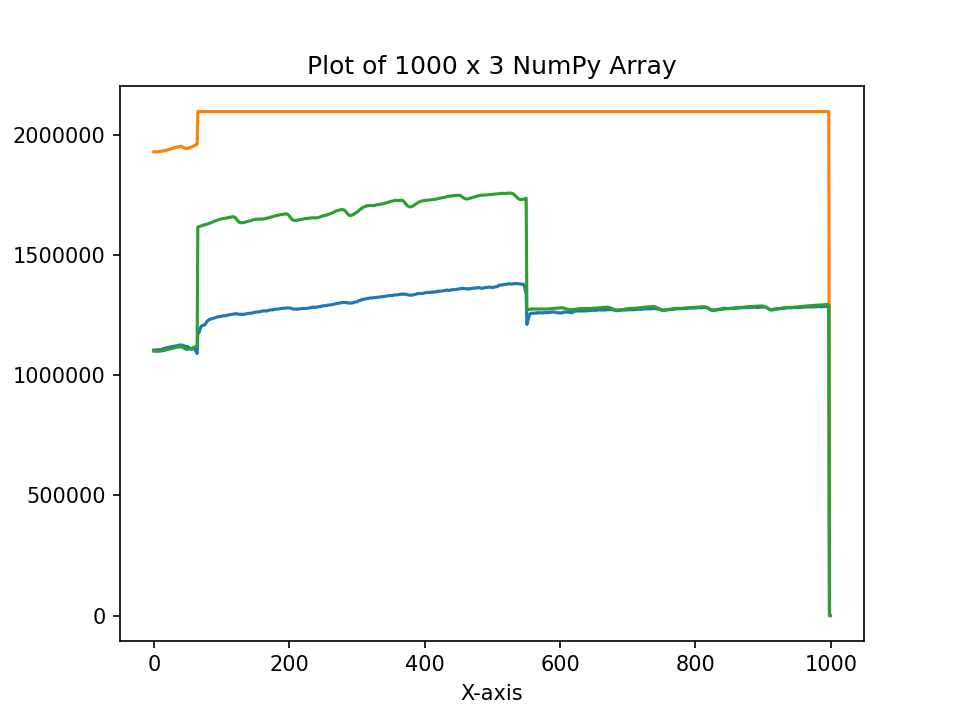

In [3]:
%matplotlib notebook


import numpy as np
import matplotlib.pyplot as plt

# Generate random data with dimensions 1000 x 3
data = int_array_1

# Create a figure and axes
fig, ax = plt.subplots()

ax.ticklabel_format(style='plain')
# Plot each feature as a separate line
for i in range(data.shape[1]):
    ax.plot(data[:, i])

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Plot of 1000 x 3 NumPy Array')

# Display the plot
plt.show()

In [3]:
def run_animation(ser):
    fig = plt.figure()
    ax = fig.add_subplot()

    time_series = []
    #line_1 = np.zeros(50)
    line_1 = []
    line_2 = []
    line_3 = []
    line_4 = []
    line_5 = []
    line_6 = []
    print("HEREEEE 1")

    start_time = datetime.now()
    

    def animated(i):
        nonlocal ser

        time = datetime.now()

        if((time - start_time).total_seconds() > 10):
            ser.write(struct.pack('b', -1))
            print("STOP ACQUISITION")
            ani.event_source.stop() 

        time_series.append(time)

        print("HEREEEE 2")
        config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
        sensor_data = ser.read(12)
        # Convert the byte string to a NumPy array of big-endian 32-bit integers
        int_array_1 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
        #time.sleep(0.1)
        config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
        sensor_data = ser.read(12)
        # Convert the byte string to a NumPy array of big-endian 32-bit integers
        int_array_2 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
#            print("INT ARR 1", int_array_1)
#             print("INT ARR 2", int_array_2)

        if(len(line_1) >= 50):
            line_1.pop(0)
            time_series.pop(0)  
#                line_4.pop(0)
#                line_2.pop(0)

#                 line_3.pop(0)

#                line_5.pop(0)
#                line_6.pop(0)

#            line_1[:-1] = line_1[1:]
#            line_1[-1] = int_array_1[1]
        line_1.append(int_array_1[1])
#            line_2.append(int_array_1[1])
#             line_3.append(int_array_1[2])
#            line_4.append(int_array_2[0])
#            line_5.append(int_array_2[1])
#            line_6.append(int_array_2[2])

        ax.clear()
        ax.ticklabel_format(style='plain')

        plt.title('An animated graph')
        plt.xlabel('Time')
        plt.ylabel('values')

        print("BEFORE ERRROR")
        print(time_series)
        print(line_1)

        red = ax.plot(time_series, line_1, label='line_1', visible = True)
#            green = ax.plot(time_series, line_2, label='line_2')
#            blue = ax.plot(time_series, line_3, label='line_3')
#            red_2 = ax.plot(time_series, line_4, label='line_4')
#            green_2 = ax.plot(time_series, line_5, label='line_5')
#            blue_2 = ax.plot(time_series, line_6, label='line_6')
        visible_range = [min(red[0].get_data()[1]), max(red[0].get_data()[1])]
        ax.set_ylim(visible_range[0]-2000, visible_range[1]+2000)
        plt.legend()

        fig.autofmt_xdate()


        #return ([red,green,blue, red_2, green_2, blue_2])
        #return ([red,green,blue])
        #return ([red_2,green_2,blue_2])
        return ([red])

    ani = animation.FuncAnimation(fig,
                                  animated, cache_frame_data=False,
                                  interval=0, blit=False)

In [ ]:
# ser.write(struct.pack('b', -1))
# print("STOP ACQUISITION")

READING PORTS
READING PORTS
READING PORTS


<IPython.core.display.Javascript object>


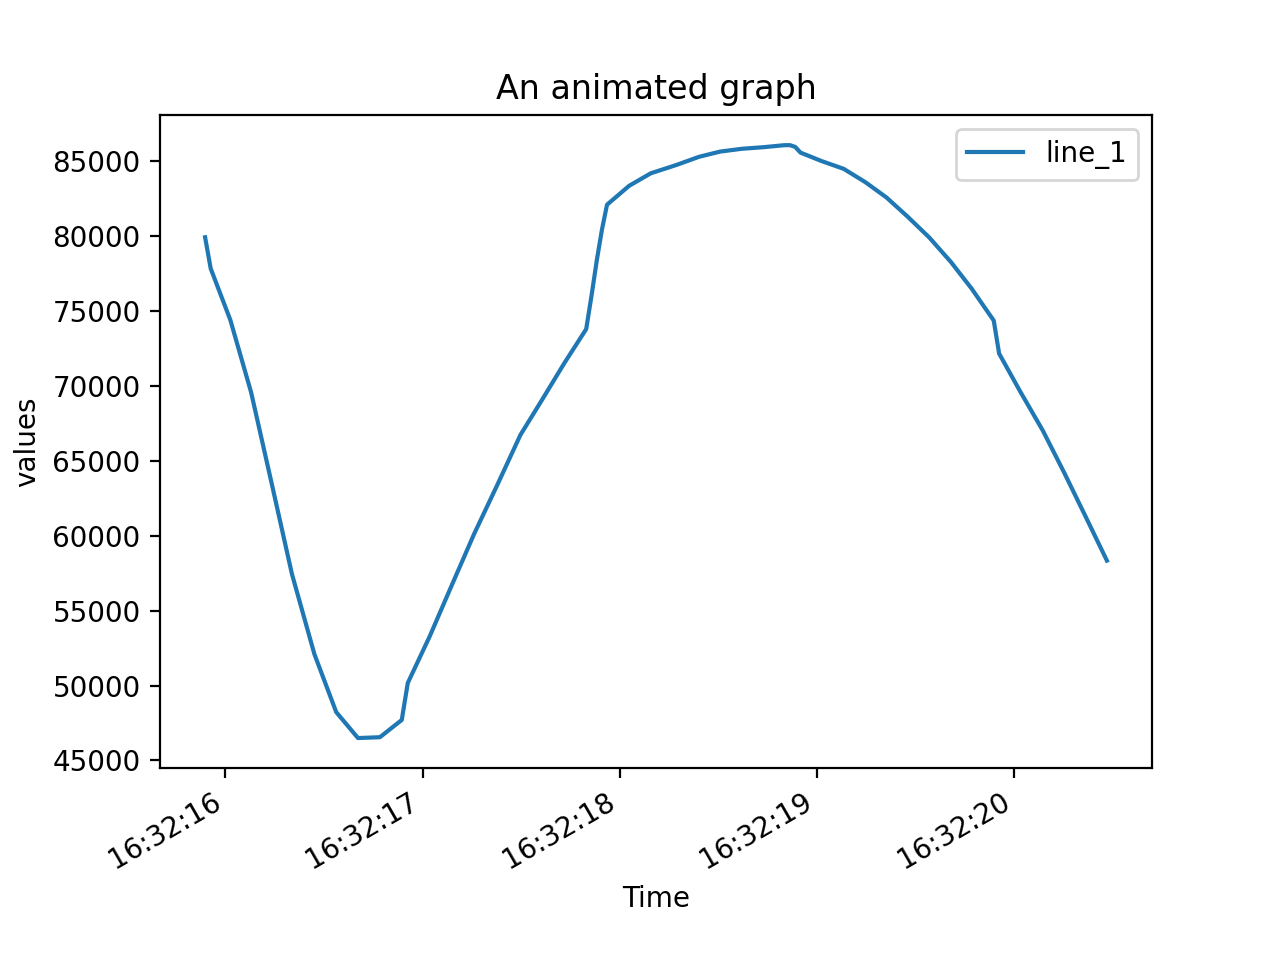

HEREEEE 1
ASJDASD


In [1]:
%matplotlib notebook
import serial
import time
import struct
import numpy as np
import sys
import glob
from datetime import datetime
from random import randint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def get_sensor_data():
    def serial_ports():
        """ Lists serial port names

            :raises EnvironmentError:
                On unsupported or unknown platforms
            :returns:
                A list of the serial ports available on the system
        """
        if sys.platform.startswith('win'):
            ports = ['COM%s' % (i + 1) for i in range(256)]
        elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
            # this excludes your current terminal "/dev/tty"
            ports = glob.glob('/dev/tty[A-Za-z]*')
        elif sys.platform.startswith('darwin'):
            ports = glob.glob('/dev/tty.*')
        else:
            raise EnvironmentError('Unsupported platform')

        result = []
        for port in ports:
            try:
                s = serial.Serial(port)
                s.close()
                result.append(port)
            except (OSError, serial.SerialException):
                pass
        return result

    for ports in serial_ports():
        print("READING PORTS")

        ser = serial.Serial(port=ports, baudrate=115200, timeout=.1)
        ser.write(bytes([126,1]))
        time.sleep(0.1)
        
        ser.write(bytes([127]))
        preamb = int.from_bytes(ser.read(4), byteorder='big')
        if preamb == 0:
            continue

        configurations = np.frombuffer(ser.read(8), dtype=np.uint8, count=8)
        info_1 = {"Preamble: ": preamb, "Command code sent": configurations[0], 
                    "Current DAQ configuration (board type)": configurations[1], 
                    "Number of used ADC channels": configurations[2], 
                    "Number of bytes in one channel of ADC": configurations[3],
                    "Number of connected optical sensors": configurations[4], 
                    "Number of channels of optical sensors": configurations[5],
                    "Number of bytes in one optical channel": configurations[6], 
                    "Sampling rate of optical sensor": configurations[7]}
        ser.write(bytes([0, 6]))
        preamb = int.from_bytes(ser.read(4), byteorder='big')
        start_info = np.frombuffer(ser.read(3), dtype=np.uint8, count=3)
        info_2 = {"Preamble: ": preamb, "ID": start_info[0], "Not used_1": start_info[1], "Not used_2": start_info[2]}

    # The figure is the actual graph while the subplot is the axis of the graph.
    return (ser)

ser = get_sensor_data()

fig = plt.figure()
ax = fig.add_subplot()


time_series = []
#line_1 = np.zeros(50)
line_1 = []
line_2 = []
line_3 = []
line_4 = []
line_5 = []
line_6 = []
print("HEREEEE 1")

start_time = datetime.now()
def animated(i):
    time = datetime.now()

    if((time - start_time).total_seconds() > 15):
        ser.write(struct.pack('b', -1))
        ani.event_source.stop() 

    time_series.append(time)

    config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
    sensor_data = ser.read(12)
    # Convert the byte string to a NumPy array of big-endian 32-bit integers
    int_array_1 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
    #time.sleep(0.1)
    config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
    sensor_data = ser.read(12)
    # Convert the byte string to a NumPy array of big-endian 32-bit integers
    int_array_2 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
#            print("INT ARR 1", int_array_1)
#             print("INT ARR 2", int_array_2)
    #counter = counter + 1
    if(len(line_1) >= 50):
        line_1.pop(0)
        time_series.pop(0)  
#                line_4.pop(0)
#                line_2.pop(0)

#                 line_3.pop(0)

#                line_5.pop(0)
#                line_6.pop(0)

#            line_1[:-1] = line_1[1:]
#            line_1[-1] = int_array_1[1]
    line_1.append(int_array_1[1])
#            line_2.append(int_array_1[1])
#             line_3.append(int_array_1[2])
#            line_4.append(int_array_2[0])
#            line_5.append(int_array_2[1])
#            line_6.append(int_array_2[2])

    ax.clear()
    ax.ticklabel_format(style='plain')
    fig.autofmt_xdate()

    plt.title('An animated graph')
    plt.xlabel('Time')
    plt.ylabel('values')

    red = ax.plot(time_series, line_1, label='line_1', visible = True)
#            green = ax.plot(time_series, line_2, label='line_2')
#            blue = ax.plot(time_series, line_3, label='line_3')
#            red_2 = ax.plot(time_series, line_4, label='line_4')
#            green_2 = ax.plot(time_series, line_5, label='line_5')
#            blue_2 = ax.plot(time_series, line_6, label='line_6')
    visible_range = [min(red[0].get_data()[1]), max(red[0].get_data()[1])]
    ax.set_ylim(visible_range[0]-2000, visible_range[1]+2000)
    plt.legend()



    #return ([red,green,blue, red_2, green_2, blue_2])


ani = animation.FuncAnimation(fig,
                              animated, cache_frame_data=False,
                              interval=10, blit=False)
plt.show()
print("ASJDASD")

In [2]:
line_6

[95162,
 95228,
 95222,
 95144,
 95174,
 95180,
 95193,
 95196,
 95185,
 95208,
 95172,
 95221,
 95150,
 95214,
 95186,
 95213,
 95209,
 95198,
 95108,
 95222,
 95228,
 95205,
 95159,
 95211,
 95238,
 95209,
 95238,
 95214,
 95373,
 95203,
 95177,
 95178,
 95115,
 95253,
 95212,
 95267,
 95172,
 95160,
 95214,
 95168,
 95097,
 95214,
 95280,
 95416,
 95210,
 95257,
 95238,
 95357,
 95186,
 95246,
 95206,
 95178,
 95218,
 95176,
 95225,
 95149,
 95172,
 95098,
 95175,
 95112,
 95130,
 95102,
 95090,
 95059,
 95213,
 95118,
 95114,
 95057,
 95079,
 95078,
 95130,
 95320,
 95331,
 95373,
 95253,
 95290,
 95297,
 95217,
 95351,
 95292,
 95251,
 95313,
 95271,
 95288,
 95296]

READING PORTS
READING PORTS
READING PORTS


<IPython.core.display.Javascript object>


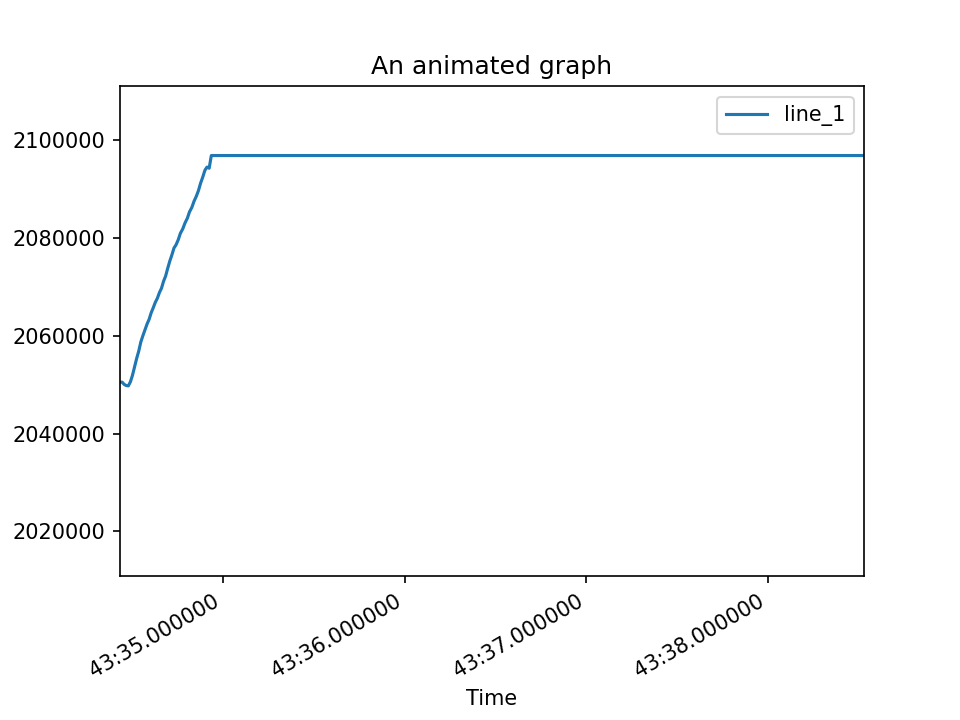

HEREEEE 1
STOP ACQUISITION


In [2]:
%matplotlib notebook
import serial
import time
import struct
import numpy as np
import sys
import glob
from datetime import datetime
from random import randint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def get_sensor_data():
    
    global ani

    def serial_ports():
        """ Lists serial port names

            :raises EnvironmentError:
                On unsupported or unknown platforms
            :returns:
                A list of the serial ports available on the system
        """
        if sys.platform.startswith('win'):
            ports = ['COM%s' % (i + 1) for i in range(256)]
        elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
            # this excludes your current terminal "/dev/tty"
            ports = glob.glob('/dev/tty[A-Za-z]*')
        elif sys.platform.startswith('darwin'):
            ports = glob.glob('/dev/tty.*')
        else:
            raise EnvironmentError('Unsupported platform')

        result = []
        for port in ports:
            try:
                s = serial.Serial(port)
                s.close()
                result.append(port)
            except (OSError, serial.SerialException):
                pass
        return result

    for ports in serial_ports():
        print("READING PORTS")

        ser = serial.Serial(port=ports, baudrate=115200, timeout=.1)
        ser.write(bytes([126,1]))
        time.sleep(0.1)
        
        ser.write(bytes([127]))
        preamb = int.from_bytes(ser.read(4), byteorder='big')
        if preamb == 0:
            continue

        configurations = np.frombuffer(ser.read(8), dtype=np.uint8, count=8)
        info_1 = {"Preamble: ": preamb, "Command code sent": configurations[0], 
                    "Current DAQ configuration (board type)": configurations[1], 
                    "Number of used ADC channels": configurations[2], 
                    "Number of bytes in one channel of ADC": configurations[3],
                    "Number of connected optical sensors": configurations[4], 
                    "Number of channels of optical sensors": configurations[5],
                    "Number of bytes in one optical channel": configurations[6], 
                    "Sampling rate of optical sensor": configurations[7]}
        ser.write(bytes([0, 6]))
        preamb = int.from_bytes(ser.read(4), byteorder='big')
        start_info = np.frombuffer(ser.read(3), dtype=np.uint8, count=3)
        info_2 = {"Preamble: ": preamb, "ID": start_info[0], "Not used_1": start_info[1], "Not used_2": start_info[2]}

    # The figure is the actual graph while the subplot is the axis of the graph.
    return (ser)

ser = get_sensor_data()
fig = plt.figure()
ax = fig.add_subplot()

time_series = []
#time_series = np.arange(0, 500)
line_1 = np.zeros(500) #5 seconds of data #1second->100 points
#line_1 = []
line_2 = []
line_3 = []
line_4 = []
line_5 = []
line_6 = []
print("HEREEEE 1")

start_time = datetime.now()

def get_data(ser):
    config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
    sensor_data = ser.read(12)
    # Convert the byte string to a NumPy array of big-endian 32-bit integers
    int_array_1 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
    #time.sleep(0.1)
    config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
    sensor_data = ser.read(12)
    # Convert the byte string to a NumPy array of big-endian 32-bit integers
    int_array_2 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
    
    return (int_array_1, int_array_2)


while(True):
    time = datetime.now()

    if((time - start_time).total_seconds() > 10):
        ser.write(struct.pack('b', -1))
        break

#     time_series[:-1] = time_series[1:]
#     time_series[-1] = time
    time_series.append(time)

    int_array_1, int_array_2 = get_data(ser)
    
    line_1[:-1] = line_1[1:]
    line_1[-1] = int_array_1[1]
    
    ax.clear()
    ax.ticklabel_format(style='plain')

    plt.title('An animated graph')
    plt.xlabel('Time')
    plt.ylabel('values')
    if(line_1[0] != 0):
     
        red = ax.plot(time_series, line_1, label='line_1', visible = True)

        plt.legend()

        fig.autofmt_xdate()

        plt.show()
        time_series.pop(0)
ser.write(struct.pack('b', -1))
print("STOP ACQUISITION")
def animated(i):

    time = datetime.now()

    if((time - start_time).total_seconds() > 10):
        ser.write(struct.pack('b', -1))
        print("STOP ACQUISITION")
        
        ani.event_source.stop() 

    time_series.append(time.total_seconds())

    print("HEREEEE 2")
    int_array_1, int_array_2 = get_data(ser)



    print(int_array_1)
    line_1[:-1] = line_1[1:]
    line_1[-1] = int_array_1[1]
    print(int_array_2)

#     ax.clear()
#     ax.ticklabel_format(style='plain')

#     plt.title('An animated graph')
#     plt.xlabel('Time')
#     plt.ylabel('values')


#    red = ax.plot(time_series, line_1, label='line_1', visible = True)
#            green = ax.plot(time_series, line_2, label='line_2')
#            blue = ax.plot(time_series, line_3, label='line_3')
#            red_2 = ax.plot(time_series, line_4, label='line_4')
#            green_2 = ax.plot(time_series, line_5, label='line_5')
#            blue_2 = ax.plot(time_series, line_6, label='line_6')
#    visible_range = [min(red[0].get_data()[1]), max(red[0].get_data()[1])]
#     ax.set_ylim(visible_range[0]-2000, visible_range[1]+2000)
#     plt.legend()

#     fig.autofmt_xdate()


    #return ([red,green,blue, red_2, green_2, blue_2])
    #return ([red,green,blue])
    #return ([red_2,green_2,blue_2])
    #return ([red])

# ani = animation.FuncAnimation(fig,
#                               animated, cache_frame_data=False,
#                               interval=0, blit=False, repeat=100, frames = 10)
#plt.show()

#print(line_1)


<IPython.core.display.Javascript object>


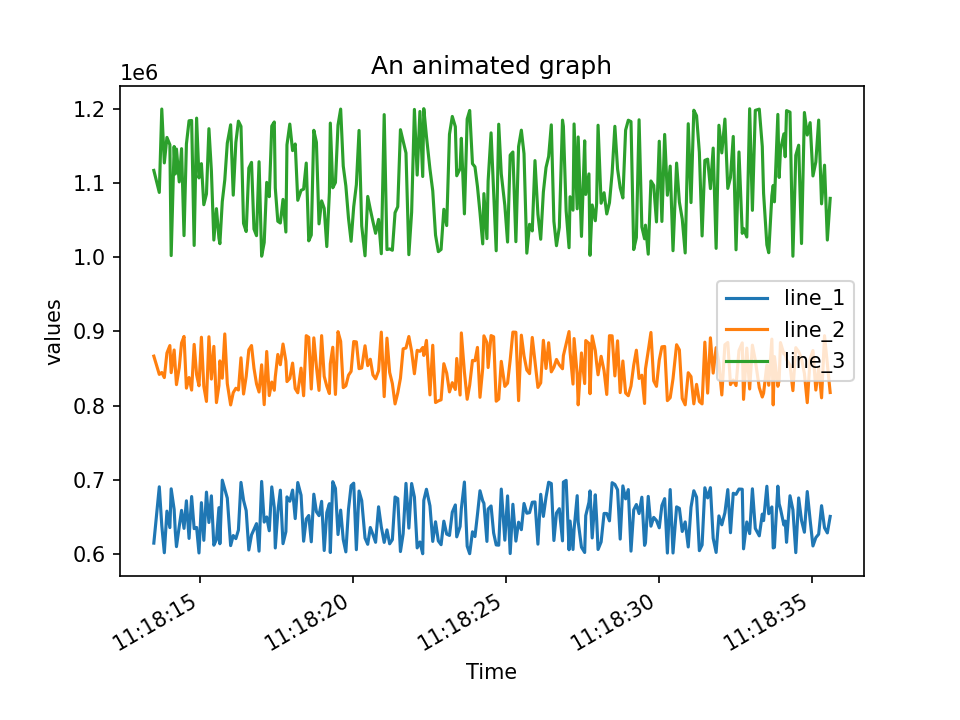

In [9]:
%matplotlib notebook

import time
from datetime import datetime
from random import randint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# The figure is the actual graph while the subplot is the axis of the graph.
fig = plt.figure()
ax = fig.add_subplot()

#def generate_dummy_data():

time_series = []
line_1 = []
line_2 = []
line_3 = []


start_time = datetime.now()


def animate(i):
    time = datetime.now()
    
#     if((time - start_time).total_seconds() > 10):
#         ani.event_source.stop()        

    time_series.append(time)
#     sensor_data = get_sensor_data()
#     print(sensor_data)
#     line_1.append(sensor_data[0])
#     line_2.append(sensor_data[1])
#     line_3.append(sensor_data[2])
    if(len(line_1) >= 1000):
        line_1.pop(0)
        line_2.pop(0)
        line_3.pop(0)
        time_series.pop(0)
        
    line_1.append(randint(600000, 700000))
    line_2.append(randint(800000, 900000))
    line_3.append(randint(1000000, 1200000))
        
    

    ax.clear()
    plt.title('An animated graph')
    plt.xlabel('Time')
    plt.ylabel('values')

    red = ax.plot(time_series, line_1, label='line_1')
    green = ax.plot(time_series, line_2, label='line_2')
    blue = ax.plot(time_series, line_3, label='line_3')


    plt.legend()

    fig.autofmt_xdate()

    return ([red,green,blue])
    
ani = animation.FuncAnimation(fig,
                              animate, cache_frame_data=False,
                              interval=10, blit=True)
plt.show()


In [37]:
current = datetime.now()


In [38]:
(datetime.now() - current).total_seconds()

3.303151

In [15]:
ax.lines

<Axes.ArtistList of 3 lines>

In [18]:
for i in ax.lines:
    print(i)

Line2D(line_1)
Line2D(line_2)
Line2D(line_3)


In [19]:
ax.lines[0]

In [46]:
ax.xaxis.get_view_interval()


array([19508.60193462, 19508.6021365 ])

In [ ]:
seconds = 5
    print("Starting data logger for {} seconds".format(seconds))
    
    

    while time.time() < end_time:

In [2]:
# %matplotlib notebook


# import serial
# import time
# import struct
# import numpy as np
# import sys
# import glob
# from datetime import datetime
# from random import randint
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation




# def get_sensor_data():
    
#     global ani

#     def serial_ports():
#         """ Lists serial port names

#             :raises EnvironmentError:
#                 On unsupported or unknown platforms
#             :returns:
#                 A list of the serial ports available on the system
#         """
#         if sys.platform.startswith('win'):
#             ports = ['COM%s' % (i + 1) for i in range(256)]
#         elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#             # this excludes your current terminal "/dev/tty"
#             ports = glob.glob('/dev/tty[A-Za-z]*')
#         elif sys.platform.startswith('darwin'):
#             ports = glob.glob('/dev/tty.*')
#         else:
#             raise EnvironmentError('Unsupported platform')

#         result = []
#         for port in ports:
#             try:
#                 s = serial.Serial(port)
#                 s.close()
#                 result.append(port)
#             except (OSError, serial.SerialException):
#                 pass
#         return result

#     for ports in serial_ports():
#         print("READING PORTS")

#         ser = serial.Serial(port=ports, baudrate=115200, timeout=.1)
#         ser.write(bytes([126,1]))
#         time.sleep(0.1)
        
#         ser.write(bytes([127]))
#         preamb = int.from_bytes(ser.read(4), byteorder='big')
#         if preamb == 0:
#             continue

#         configurations = np.frombuffer(ser.read(8), dtype=np.uint8, count=8)
#         info_1 = {"Preamble: ": preamb, "Command code sent": configurations[0], 
#                     "Current DAQ configuration (board type)": configurations[1], 
#                     "Number of used ADC channels": configurations[2], 
#                     "Number of bytes in one channel of ADC": configurations[3],
#                     "Number of connected optical sensors": configurations[4], 
#                     "Number of channels of optical sensors": configurations[5],
#                     "Number of bytes in one optical channel": configurations[6], 
#                     "Sampling rate of optical sensor": configurations[7]}
#         ser.write(bytes([0, 6]))
#         preamb = int.from_bytes(ser.read(4), byteorder='big')
#         start_info = np.frombuffer(ser.read(3), dtype=np.uint8, count=3)
#         info_2 = {"Preamble: ": preamb, "ID": start_info[0], "Not used_1": start_info[1], "Not used_2": start_info[2]}

#     # The figure is the actual graph while the subplot is the axis of the graph.
#     return (ser)

# ser = get_sensor_data()

# # Initialize the figure and axes
# fig, ax = plt.subplots()

# # Initialize the x and y data
# x_data = []
# line_1 = np.zeros(100) #5 seconds of data #1second->100 points


# start_time = datetime.now()




# def get_data(ser):
#     config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
#     sensor_data = ser.read(12)
#     # Convert the byte string to a NumPy array of big-endian 32-bit integers
#     int_array_1 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
#     #time.sleep(0.1)
#     config_data = ser.read(8)   #ID -> [4], COUNTER -> [5], N_CHANNELS -> [6], N_BYTES -> [7]
#     sensor_data = ser.read(12)
#     # Convert the byte string to a NumPy array of big-endian 32-bit integers
#     int_array_2 = np.frombuffer(sensor_data, dtype=np.uint32, count=3)
    
#     return (int_array_1, int_array_2)

# # Function to update the plot for each frame
# def update_plot():
#     time = datetime.now()
    
#     int_array_1, int_array_2 = get_data(ser)
    
#     # Append the new data to the existing data
#     x_data.append(time)
    
#     line_1[:-1] = line_1[1:]
#     line_1[-1] = int_array_1[1]
#     if(line_1[0] != 0):
     
#         # Update the plot with the new data
#         ax.clear()
#         ax.ticklabel_format(style='plain')
#         my_line = ax.plot(x_data, line_1, label='line_1')
#         plt.title('An animated graph')
#         plt.xlabel('Time')
#         plt.ylabel('values')
#         ax.relim()
#         ax.autoscale_view()
#         fig.canvas.draw()
#         plt.legend()
#         fig.autofmt_xdate()
#         plt.show()
#         x_data.pop(0)
# # Run the animation in a while loop
# while True:
#     time = datetime.now()
#     # Update the plot for each frame
#     update_plot()

#     # Add any additional logic or break conditions for stopping the animation
#     if((time - start_time).total_seconds() > 50):
#         ser.write(struct.pack('b', -1))
#         break
#     # Set an appropriate interval between frames (adjust as needed)
#     #plt.pause(0.01)

# # Show the final plot
# plt.show()


<IPython.core.display.Javascript object>


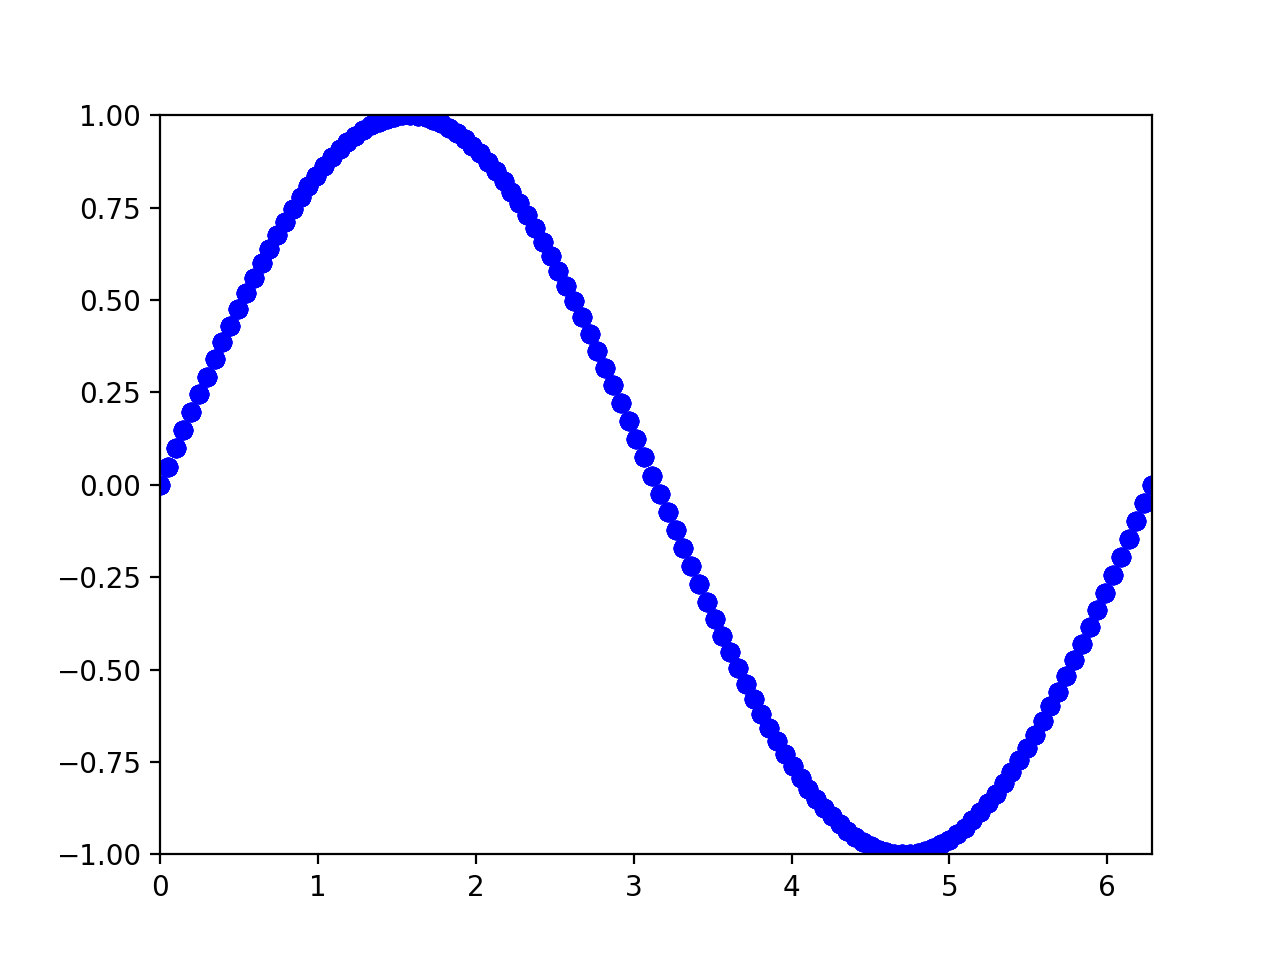

YEP


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
line, = ax.plot([], [], 'bo')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return line,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    line.set_data(xdata, ydata)
    print("YEP")
    return line,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()
print("YEP")